<a href="https://colab.research.google.com/github/rodrigourech/VTA_MC1/blob/main/Revision_Newplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# ------------------------------
# Data Import & Preparation
# ------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Quellen (GitHub Repository: MeteoSchweiz CH2018 Szenarien)
url_rcp45 = "https://raw.githubusercontent.com/rodrigourech/ivi/main/data/RCP45_tas.csv"
url_rcp85 = "https://raw.githubusercontent.com/rodrigourech/ivi/main/data/RCP85_tas.csv"

# CSVs einlesen (Best Practices: UTF-8 Encoding, parse_dates für Zeitspalten)
df_rcp45 = pd.read_csv(url_rcp45, parse_dates=["date"], encoding="utf-8-sig")
df_rcp85 = pd.read_csv(url_rcp85, parse_dates=["date"], encoding="utf-8-sig")

# Subsets für Performance-Tests (kleines vs. grosses Sample)
df_rcp45_small = df_rcp45.sample(n=3000, random_state=42).reset_index(drop=True)
df_rcp85_large = df_rcp85.sample(n=300000, random_state=42).reset_index(drop=True)

# Szenario-Label hinzufügen
df_rcp45_small["scenario"] = "RCP4.5"
df_rcp85_large["scenario"] = "RCP8.5"

# Zusammenführen
df = pd.concat([df_rcp45_small, df_rcp85_large], ignore_index=True)

# Jahr & Dekade extrahieren
df["year"] = df["date"].dt.year
df["decade"] = (df["year"] // 10) * 10

# ------------------------------
# Parameter
# ------------------------------
SELECT_SCENARIO = "RCP8.5"
stations_order  = ["Bern", "St. Gallen", "Sion"]  # gewünschte Stationen

# ------------------------------
# Aggregation: Dekadenmittel
# ------------------------------
decadal = (
    df[df["scenario"] == SELECT_SCENARIO]
    .groupby(["decade", "station"], as_index=False)["value"]
    .mean()
)

# Nur gewünschte Stationen & sortieren
decadal = decadal[decadal["station"].isin(stations_order)]
decades = sorted(decadal["decade"].unique())



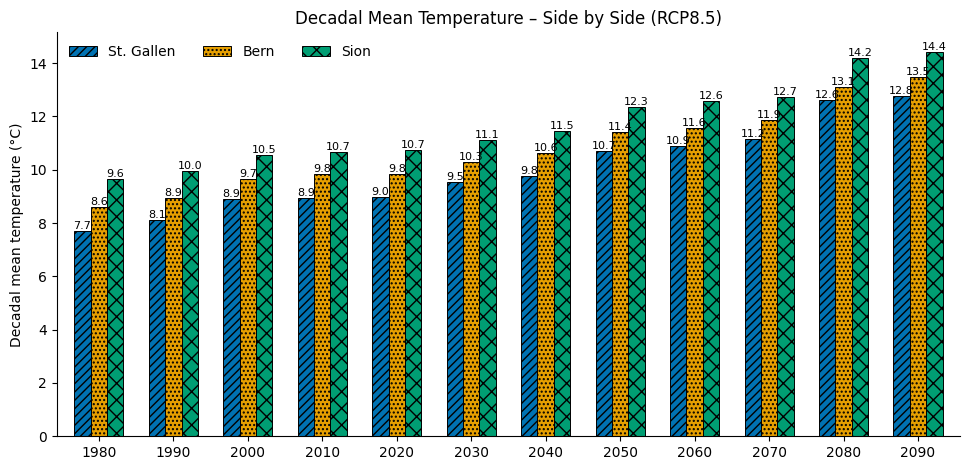

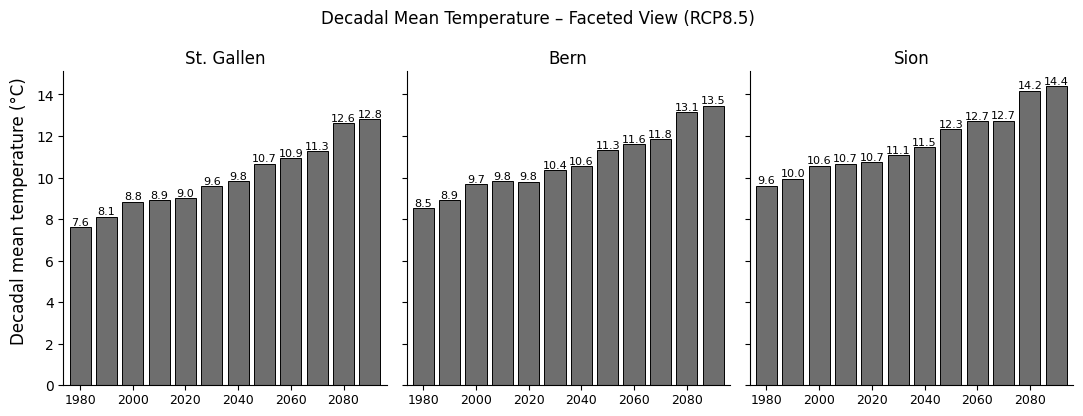

In [39]:
# =========================================================
# Figure 4 — Decadal Mean Temperature: Side-by-Side Bars
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Quelle der Daten: df_decadal (aus deinem Import-Block)
# Erwartet Spalten: ['decade','station','scenario','value_decade_mean']

SELECT_SCENARIO = "RCP8.5"  # oder "RCP4.5"
stations_order  = ["St. Gallen", "Bern", "Sion"]

# Daten für gewähltes Szenario + Stationen
decadal_plot = (
    df_decadal[df_decadal["scenario"] == SELECT_SCENARIO]
    .query("station in @stations_order")
    .rename(columns={"value_decade_mean": "value"})
    .copy()
)

decades = np.array(sorted(decadal_plot["decade"].unique()))
x = np.arange(len(decades))
bar_w = 0.22

# Okabe–Ito + Hatches
okabe_ito = {"St. Gallen": "#0072B2", "Bern": "#E69F00", "Sion": "#009E73"}
hatches   = {"St. Gallen": "////",    "Bern": "....",    "Sion": "xx"}

fig, ax = plt.subplots(figsize=(9.8, 4.8))

for i, st in enumerate(stations_order):
    sub = (
        decadal_plot[decadal_plot["station"] == st]
        .set_index("decade")
        .reindex(decades)["value"]
    )
    y = sub.to_numpy()
    off = (i - 1) * bar_w

    ax.bar(
        x + off, y, width=bar_w,
        color=okabe_ito.get(st, "#999999"),
        edgecolor="black", linewidth=0.7,
        hatch=hatches.get(st, ""), label=st
    )

    # optionale Werte-Labels
    for xi, yi in zip(x + off, y):
        if pd.notna(yi):
            ax.text(xi, yi, f"{yi:.1f}", ha="center", va="bottom", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels([str(d) for d in decades])
ax.set_ylabel("Decadal mean temperature (°C)")
ax.set_title(f"Decadal Mean Temperature – Side by Side ({SELECT_SCENARIO})")
ax.legend(ncol=len(stations_order), frameon=False)
ax.spines[["top", "right"]].set_visible(False)
ax.margins(x=0.02)
plt.tight_layout()
plt.show()


# ==============================================
# Figure 5 — Faceted View
# ==============================================

# Globale Dekaden für alle Facets (gleiche X-Positionen)
all_decades = np.array(sorted(decadal["decade"].unique()))
xpos = np.arange(len(all_decades))

# Dynamische Ausdünnung der Ticklabels
if len(all_decades) <= 8:
    step = 1
elif len(all_decades) <= 12:
    step = 2
else:
    step = 3
tick_idx = np.arange(0, len(all_decades), step)
tick_labels = [str(d) for d in all_decades[tick_idx]]

cols = len(stations_order)
fig, axes = plt.subplots(1, cols, figsize=(max(11, 3.0*cols), 4.2), sharey=True)

for ax, st in zip(axes, stations_order):
    # Serie pro Station auf alle Dekaden alignen (fehlende -> NaN)
    sub = (
        decadal[decadal["station"] == st]
        .set_index("decade")
        .reindex(all_decades)["value"]
    )

    ax.bar(xpos, sub.values, color="#6e6e6e", edgecolor="black", linewidth=0.7)

    # Dezente Werte-Labels (optional)
    for xi, yi in zip(xpos, sub.values):
        if pd.notna(yi):
            ax.text(xi, yi, f"{yi:.1f}", ha="center", va="bottom", fontsize=8)

    ax.set_title(st)
    ax.spines[["top", "right"]].set_visible(False)
    ax.margins(x=0.02)

    # Feste Ticks & horizontal beschriftet, ausgedünnt
    ax.set_xticks(xpos[tick_idx])
    ax.set_xticklabels(tick_labels, rotation=0, ha="center", fontsize=9)
    ax.tick_params(axis="x", labelrotation=0, pad=2)

fig.supylabel("Decadal mean temperature (°C)")
fig.suptitle(f"Decadal Mean Temperature – Faceted View ({SELECT_SCENARIO})")
plt.tight_layout()
plt.show()
